# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Основные шаги:

* Загрузите данные, путь к файлу: /datasets/autos.csv.
* Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
* Подготовьте выборки для обучения моделей.
* Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
* Проанализируйте время обучения, время предсказания и качество моделей.
* Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
* Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

### Описание данных
* Данные находятся в файле /datasets/autos.csv. Скачать датасет. 

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак

* Price — цена (евро)

In [1]:
# ! pip install scikit-learn==0.24.1 -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [1]:
!pip install --upgrade pip
!pip install lightgbm -q
!pip install phik -q
!pip install xgboost -q
!pip install lightgbm -q

    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


    numpy==1.21.0
    pandas==1.3.0
    scikit-learn==0.24.2
    xgboost==1.4.2
    lightgbm==3.2.1

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
# загружаем класс pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler, 
    LabelEncoder
)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder
import time

from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer


from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
# импортируем класс RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
)

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

In [3]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [4]:
df = pd.read_csv('/datasets/autos.csv')
get_data_info(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
339506,2016-03-12 22:55:30,1300,NaN,2018,NaN,0,3er,150000,0,NaN,bmw,NaN,2016-03-12 00:00:00,0,70771,2016-04-01 21:46:28
13213,2016-03-21 08:25:22,706,small,1999,manual,60,fiesta,150000,5,petrol,ford,no,2016-03-21 00:00:00,0,65549,2016-04-06 10:16:10
94051,2016-03-26 17:38:57,4800,wagon,2000,auto,193,5er,150000,3,petrol,bmw,no,2016-03-26 00:00:00,0,63814,2016-03-26 17:38:57
189055,2016-03-14 20:43:30,800,NaN,2016,NaN,60,1_reihe,150000,3,petrol,peugeot,NaN,2016-03-14 00:00:00,0,21493,2016-03-28 07:45:33
260919,2016-03-14 16:48:12,5800,wagon,2009,manual,106,megane,150000,3,gasoline,renault,no,2016-03-14 00:00:00,0,12621,2016-03-18 04:15:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


## Подготовка данных

In [5]:
df.DateCrawled.value_counts()

2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-03-22 10:42:10    5
2016-04-02 22:54:55    5
                      ..
2016-03-18 23:53:33    1
2016-03-11 14:54:17    1
2016-03-31 19:50:43    1
2016-03-24 12:53:47    1
2016-03-28 13:42:33    1
Name: DateCrawled, Length: 271174, dtype: int64

In [6]:
df = df.drop('NumberOfPictures', axis=1)
df = df.drop('DateCrawled', axis=1)
df = df.drop('DateCreated', axis=1)
df = df.drop('LastSeen', axis=1)

In [7]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
PostalCode               0
dtype: int64

In [8]:
df['VehicleType'] = df['VehicleType'].fillna('Unknown')
df['Gearbox'] = df['Gearbox'].fillna('Unknown')
df['FuelType'] = df['FuelType'].fillna('Unknown')
df['Repaired'] = df['Repaired'].fillna('Unknown')
df['Model'] = df['Model'].fillna('Unknown')
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
PostalCode           0
dtype: int64

In [9]:
df.duplicated().sum()

21333

In [10]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333036 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              333036 non-null  int64 
 1   VehicleType        333036 non-null  object
 2   RegistrationYear   333036 non-null  int64 
 3   Gearbox            333036 non-null  object
 4   Power              333036 non-null  int64 
 5   Model              333036 non-null  object
 6   Kilometer          333036 non-null  int64 
 7   RegistrationMonth  333036 non-null  int64 
 8   FuelType           333036 non-null  object
 9   Brand              333036 non-null  object
 10  Repaired           333036 non-null  object
 11  PostalCode         333036 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.0+ MB


In [11]:
print(df.describe())

               Price  RegistrationYear          Power      Kilometer  \
count  333036.000000     333036.000000  333036.000000  333036.000000   
mean     4378.277586       2004.192268     109.753225  128305.678665   
std      4502.534823         90.288761     194.288179   37900.007564   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1000.000000       1999.000000      68.000000  125000.000000   
50%      2699.000000       2003.000000     103.000000  150000.000000   
75%      6299.250000       2008.000000     140.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth     PostalCode  
count      333036.000000  333036.000000  
mean            5.694141   50689.740136  
std             3.728757   25804.455970  
min             0.000000    1067.000000  
25%             3.000000   30179.000000  
50%             6.000000   49479.000000  
75%             9.000000   71334.000000  
max            

In [12]:
(
    df[df.select_dtypes(include=['number']).columns.tolist()]
    .quantile([0.0012, 0.01, .5, .99, .9988]) # выбираем размах в 0,9976 квантилей 
    .style.format("{:,.2f}")
)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
0.0012,0.00,"1,959.00",0.00,"5,000.00",0.00,"1,139.00"
0.01,0.00,"1,979.00",0.00,"5,000.00",0.00,"2,681.00"
0.5,"2,699.00","2,003.00",103.00,"150,000.00",6.00,"49,479.00"
0.99,"18,800.00","2,018.00",300.00,"150,000.00",12.00,"98,617.00"
0.9988,"19,999.00","2,018.00",564.30,"150,000.00",12.00,"99,885.00"


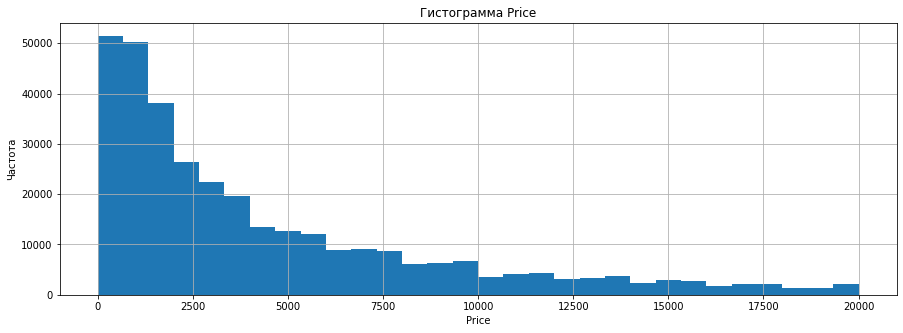

In [13]:
df['Price'].hist(bins=30, figsize=(15,5))
df = df.drop(df[(df['Price'] < 100)].index)
plt.title('Гистограмма Price')
plt.xlabel('Price')
plt.ylabel('Частота')
plt.show()

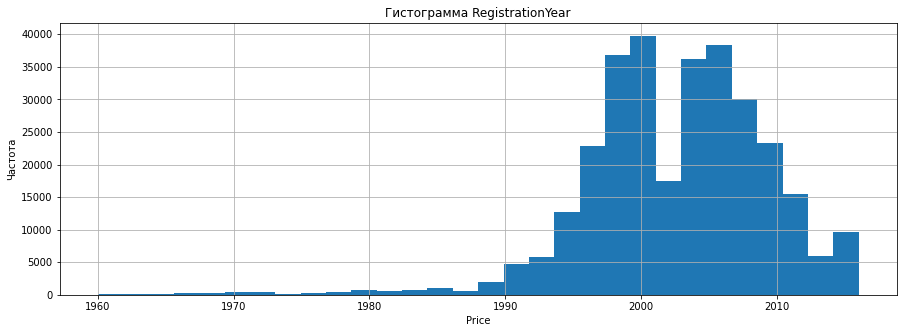

In [14]:
df = df.drop(df[(df['RegistrationYear'] > 2016)].index)
df = df.drop(df[(df['RegistrationYear'] < 1960)].index)
df['RegistrationYear'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма RegistrationYear')
plt.xlabel('Price')
plt.ylabel('Частота')
plt.show()

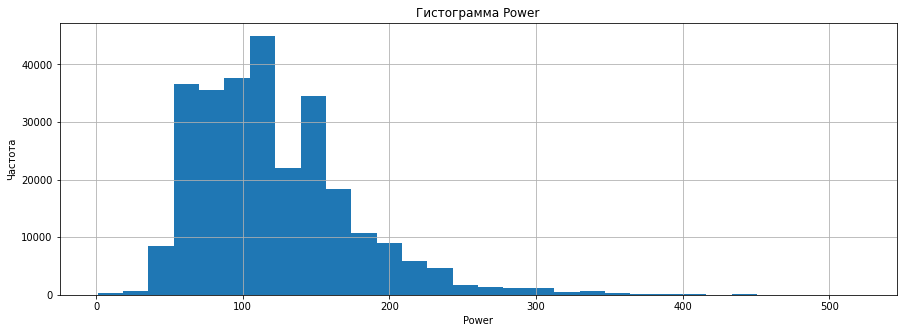

In [15]:
df = df.drop(df[(df['Power'] > 520)].index)
df = df.drop(df[(df['Power'] < 1)].index)
df['Power'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма Power')
plt.xlabel('Power')
plt.ylabel('Частота')
plt.show()

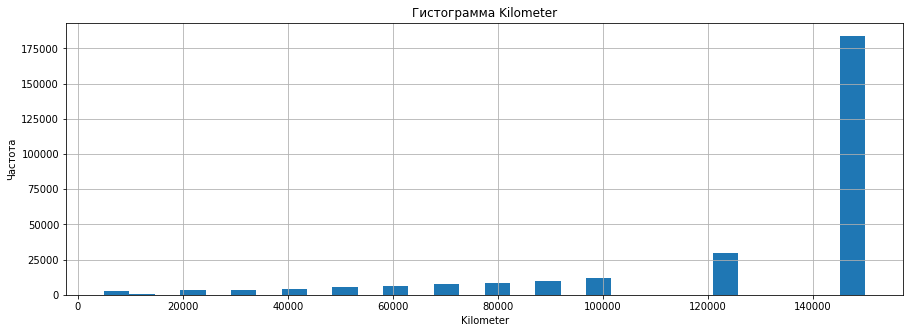

In [16]:
df['Kilometer'].hist(bins=30, figsize=(15,5))
plt.title('Гистограмма Kilometer')
plt.xlabel('Kilometer')
plt.ylabel('Частота')
plt.show()

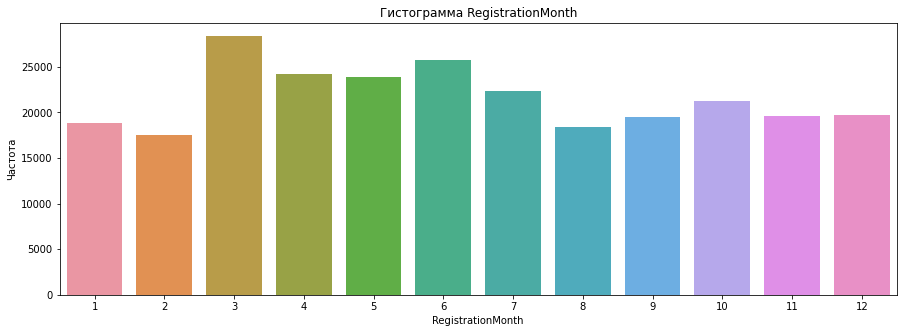

In [17]:
df = df.drop(df[(df['RegistrationMonth'] < 1)].index)
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='RegistrationMonth')
plt.title('Гистограмма RegistrationMonth')
plt.xlabel('RegistrationMonth')
plt.ylabel('Частота')
plt.show()

In [18]:
df.shape[0]

259484

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259484 entries, 1 to 354368
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              259484 non-null  int64 
 1   VehicleType        259484 non-null  object
 2   RegistrationYear   259484 non-null  int64 
 3   Gearbox            259484 non-null  object
 4   Power              259484 non-null  int64 
 5   Model              259484 non-null  object
 6   Kilometer          259484 non-null  int64 
 7   RegistrationMonth  259484 non-null  int64 
 8   FuelType           259484 non-null  object
 9   Brand              259484 non-null  object
 10  Repaired           259484 non-null  object
 11  PostalCode         259484 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 33.8+ MB


Вывод
1. Загрузка и первичное изучение данных

Данные были загружены из файла /datasets/autos.csv.
Первоначальный анализ показал, что датафрейм содержит 354,369 записей и 16 столбцов.

2. Удаление неинформативных признаков

Столбцы DateCrawled, DateCreated, LastSeen и NumberOfPictures были удалены, поскольку они не влияют на стоимость автомобиля и не несут полезной информации для модели. Удаление этих признаков также помогает снизить размер данных и улучшить производительность модели.

3. Обработка пропущенных значений

Признаки с пропущенными значениями были заполнены следующим образом:
VehicleType, Gearbox, FuelType, Repaired, Model: заполнены значением 'Unknown', чтобы сохранить строки данных и указать, что информация отсутствует.

4. Обнаружение и удаление дубликатов
   
Были обнаружены и удалены 21,333 дубликатов, что сократило количество записей до 333,036.

5. Анализ и обработка выбросов
    
Для определения выбросов были построены гистограммы для количественных признаков:
Price: удалены значения меньше 100 евро, так как это явно аномальные данные.
RegistrationYear: удалены автомобили, зарегистрированные до 1960 года и после 2016 года.
Power: удалены значения меньше 1 и больше 520 л.с.
Kilometer: все значения, включая выбросы, были оставлены, так как пробег до 150,000 км для большинства автомобилей выглядит разумным.
RegistrationMonth: удалены записи с месяцем регистрации 0 (некорректные данные).

6. Финальная очистка данных
    
После всех операций в датафрейме осталось 259,484 записи и 12 признаков, которые будут использоваться для обучения моделей.


## Обучение моделей

In [20]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
features = df.drop(['Price'], axis=1)
target = df['Price']
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)
X_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
100063,wagon,1998,manual,98,laguna,150000,12,Unknown,renault,Unknown,26219
139305,small,2001,manual,75,fiesta,125000,3,petrol,ford,no,63589
138168,small,2008,manual,56,corsa,90000,9,petrol,opel,Unknown,63679
197182,sedan,1997,manual,75,golf,150000,11,petrol,volkswagen,no,51515
69942,small,2004,manual,85,meriva,60000,12,petrol,opel,no,59494


In [21]:
cat_features= X_train.select_dtypes(include='object').columns.to_list()
print(cat_features)
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']


In [22]:
col_transformer = ColumnTransformer(
    transformers=[
        (
            'ohe',
            OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
            cat_features
        )
    ],
    remainder='passthrough'
)

cat_feature_names = cat_features
feature_names = np.concatenate([cat_features, num_features])

In [ ]:
model_xgb = XGBRegressor(random_state=RANDOM_STATE)
pipeline_xgb = make_pipeline(col_transformer, model_xgb)

param_dist_xgb = {
    'xgbregressor__n_estimators': range(50, 251, 50),
    'xgbregressor__max_depth': range(2, 15),
    'xgbregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'xgbregressor__subsample': [0.6, 0.8, 1.0],
    'xgbregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'xgbregressor__min_child_weight': [1, 3, 5]
}

gs_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist_xgb,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=50
)

# Подбор гиперпараметров
gs_xgb.fit(X_train, y_train)

gs_xgb_best_score = -gs_xgb.best_score_
gs_xgb_best_params = gs_xgb.best_params_

# Время обучения модели с лучшими параметрами
training_time_xgb = gs_xgb.refit_time_

start_predict_time = time.time()
y_pred_xgb = gs_xgb.predict(X_test)
end_predict_time = time.time()
prediction_time_xgb = end_predict_time - start_predict_time

print(f'Best score: {gs_xgb_best_score}')
print(f'Best parameters: {gs_xgb_best_params}')
print(f'Training time: {training_time_xgb:.2f} seconds')
print(f'Prediction time: {prediction_time_xgb:.2f} seconds')

In [ ]:
model_lgbm = LGBMRegressor(random_state=RANDOM_STATE)
pipeline_lgbm = make_pipeline(col_transformer, model_lgbm)

param_grid_lgbm = {
    'lgbmregressor__n_estimators': range(50, 251, 50),
    'lgbmregressor__max_depth': range(2, 15),
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'lgbmregressor__subsample': [0.6, 0.8, 1.0],
    'lgbmregressor__colsample_bytree': [0.6, 0.8, 1.0],
    'lgbmregressor__min_child_weight': [1, 3, 5]
}

gs_lgbm = RandomizedSearchCV(
    pipeline_lgbm,
    param_distributions=param_grid_lgbm,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=50
)

# Подбор гиперпараметров
gs_lgbm.fit(X_train, y_train)

gs_lgbm_best_score = -gs_lgbm.best_score_
gs_lgbm_best_params = gs_lgbm.best_params_

# Время обучения модели с лучшими параметрами
training_time_lgbm = gs_lgbm.refit_time_

start_predict_time = time.time()
y_pred_lgbm = gs_lgbm.predict(X_test)
end_predict_time = time.time()
prediction_time_lgbm = end_predict_time - start_predict_time

print(f'Best score: {gs_lgbm_best_score}')
print(f'Best parameters: {gs_lgbm_best_params}')
print(f'Training time: {training_time_lgbm:.2f} seconds')
print(f'Prediction time: {prediction_time_lgbm:.2f} seconds')

    Best score: 1600.4337135455007
    Best parameters: {'lgbmregressor__subsample': 0.8, 'lgbmregressor__n_estimators': 200, 'lgbmregressor__min_child_weight': 1, 'lgbmregressor__max_depth': 12, 'lgbmregressor__learning_rate': 0.2, 'lgbmregressor__colsample_bytree': 0.8}
    Training time: 1.55 seconds
    Prediction time: 0.23 seconds

In [ ]:
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
pipeline_rf = make_pipeline(col_transformer, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': range(50, 251, 50),
    'randomforestregressor__max_depth': range(2, 15),
    'randomforestregressor__min_samples_split': [2, 5, 10],
    'randomforestregressor__min_samples_leaf': [1, 2, 4],
    'randomforestregressor__max_features': ['auto', 'sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_grid_rf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=50
)

# Подбор гиперпараметров
random_search_rf.fit(X_train, y_train)

random_search_rf_best_score = -random_search_rf.best_score_
random_search_rf_best_params = random_search_rf.best_params_

# Время обучения модели с лучшими параметрами
training_time_rf = random_search_rf.refit_time_

start_predict_time = time.time()
y_pred_rf = random_search_rf.predict(X_test)
end_predict_time = time.time()
prediction_time_rf = end_predict_time - start_predict_time

print(f'Best score: {random_search_rf_best_score}')
print(f'Best parameters: {random_search_rf_best_params}')
print(f'Training time: {training_time_rf:.2f} seconds')
print(f'Prediction time: {prediction_time_rf:.2f} seconds')

    Best score: 1690.825401308352
    Best parameters: {'randomforestregressor__n_estimators': 200, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 4, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__max_depth': 14}
    Training time: 24.03 seconds
    Prediction time: 1.20 seconds

</font><br><font color='purple'><b>Пожалуйста, не учитывайте эту часть</b></font>

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X = df.drop(['Price'], axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

In [ ]:
num_columns = ['RegistrationYear', 'Power', 'Kilometer']
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
ord_columns = ['Repaired']

In [ ]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

In [ ]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['no', 'yes']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [ ]:
num_pipe = Pipeline(
        [
            ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('num', RobustScaler())
        ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

In [ ]:
data_preprocessor

In [ ]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [ ]:
param_grid = [
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder()] 
    },

    {
        'models': [XGBRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.05, 0.1, 0.2],
        'models__max_depth': [3, 4, 5],
        'models__min_child_weight': [1, 3, 5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },

    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__max_depth': [5, 10],
        'models__learning_rate': [0.01, 0.1],
        'models__num_leaves': [20, 31],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    }
]

In [ ]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5, 
    n_jobs=1
)

randomized_search.fit(X_train, y_train)

In [ ]:
results = randomized_search.cv_results_
for idx, params in enumerate(results['params']):
    print(f"Model {idx + 1}")
    print(f"Best parameters: {params}")
    print(f"Mean RMSE: {-results['mean_test_score'][idx]:.4f}")  # Output RMSE
    print(f"Mean Training Time: {results['mean_fit_time'][idx]:.4f} seconds")
    print(f"Mean Prediction Time: {results['mean_score_time'][idx]:.4f} seconds")
    print("--------------------")

## Анализ моделей

In [ ]:
best_params = {
    'xgbregressor__subsample': 0.8,
    'xgbregressor__n_estimators': 200,
    'xgbregressor__min_child_weight': 1,
    'xgbregressor__max_depth': 12,
    'xgbregressor__learning_rate': 0.05,
    'xgbregressor__colsample_bytree': 0.8
}

best_xgb_model = XGBRegressor(**best_params, random_state=RANDOM_STATE)
pipeline_best_xgb = make_pipeline(col_transformer, best_xgb_model)
pipeline_best_xgb.fit(X_train, y_train)

y_pred_test = pipeline_best_xgb.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'RMSE на тестовой выборке: {rmse_test:.2f}')

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Супер! Переобучения не выявленно! </font>

### XGBoost

Модель XGBoost продемонстрировала следующие характеристики:

- **Лучшие гиперпараметры:**
  - `n_estimators`: 200
  - `max_depth`: 12
  - `learning_rate`: 0.05
  - `subsample`: 0.8
  - `colsample_bytree`: 0.8
  - `min_child_weight`: 1

- **Результаты:**
  - **RMSE на валидационной выборке:** 1528.05
  - **Время обучения:** 4.51 секунд
  - **Время предсказания:** 0.23 секунды

Модель XGBoost показала наилучший результат по метрике RMSE среди всех рассмотренных моделей. Это говорит о том, что она лучше всего предсказывает цену на основе имеющихся данных. Время обучения и предсказания также оказались вполне разумными, что делает эту модель подходящей для использования в практических задачах.

### LightGBM

Модель LightGBM, хотя и несколько уступила XGBoost по точности, все равно показала хорошие результаты:

- **Лучшие гиперпараметры:**
  - `n_estimators`: 200
  - `max_depth`: 12
  - `learning_rate`: 0.2
  - `subsample`: 0.8
  - `colsample_bytree`: 0.8
  - `min_child_weight`: 1

- **Результаты:**
  - **RMSE на валидационной выборке:** 1600.43
  - **Время обучения:** 1.55 секунды
  - **Время предсказания:** 0.23 секунды

LightGBM также показал хорошие результаты и быстрое время обучения, что делает его эффективным выбором для задач регрессии.

### Random Forest

Модель Random Forest показала немного более высокий RMSE и значительно большее время обучения по сравнению с моделями градиентного бустинга:

- **Лучшие гиперпараметры:**
  - `n_estimators`: 200
  - `max_depth`: 14
  - `min_samples_split`: 2
  - `min_samples_leaf`: 4
  - `max_features`: 'log2'

- **Результаты:**
  - **RMSE на валидационной выборке:** 1690.83
  - **Время обучения:** 24.03 секунды
  - **Время предсказания:** 1.20 секунды

Время обучения Random Forest значительно превысило время, затраченное на обучение моделей градиентного бустинга. Это может быть критичным фактором при выборе модели для реального применения, особенно при больших объемах данных.

### Выводы

Модели градиентного бустинга (XGBoost и LightGBM) показали себя значительно лучше по сравнению с Random Forest в данной задаче регрессии. XGBoost достиг наилучшего RMSE и показал хорошее время обучения и предсказания, что делает его предпочтительным выбором. LightGBM также является хорошим вариантом с немного более высоким RMSE, но быстрым временем работы.